In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-whitegrid')

## for dataset
import urllib.request
import zipfile
import os

In [2]:
movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
download_path = "/content/movielens"

os.makedirs(download_path, exist_ok=True)
zip_file_path = os.path.join(download_path, "ml-latest-small.zip")
urllib.request.urlretrieve(movielens_url, zip_file_path)

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(download_path)

extracted_files = os.listdir(download_path)
print("Files in the extracted directory:", extracted_files)

Files in the extracted directory: ['ml-latest-small.zip', 'ml-latest-small']


In [3]:
# Loading the dataframe
df = pd.read_csv('movielens/ml-latest-small/ratings.csv')

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
df.shape

(100836, 4)

In [6]:
df = df.drop(columns=['timestamp'])
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
user_ratings_pivot1 = df.pivot_table(index='userId', columns='movieId', values='rating')
user_ratings_pivot1.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#filling missing values by centralizing
user_ratings_pivot2 = user_ratings_pivot1.sub(user_ratings_pivot1.mean(axis=1), axis=0).fillna(0)
user_ratings_pivot2.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
target_user = user_ratings_pivot2.iloc[[1]]
target_user

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
remove_movie_we_are_predicting.head()

movieId,2,3,4,5,6,7,8,9,10,11,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
users_watched_this_movie = user_ratings_pivot1[1]
df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
df_filled_users_watched_thismovie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.366379,0.0,-0.366379,0.0,0.0,-0.366379,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.363636,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.269737,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.948148,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.290476,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
users_watched_this_movie.dropna(inplace = True)
users_watched_this_movie.head()

userId
1     4.0
5     4.0
7     4.5
15    2.5
17    4.5
Name: 1, dtype: float64

In [13]:
from sklearn.neighbors import KNeighborsRegressor
user_knn = KNeighborsRegressor(metric='cosine', n_neighbors=10)
user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred = user_knn.predict(target_user)
print(user_user_pred)

[3.55]


In [14]:
user_knn2 = KNeighborsRegressor(metric='jaccard', n_neighbors=3)
user_knn2.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred2 = user_knn2.predict(target_user)
print(user_user_pred2)

[3.66666667]


In [15]:
user_knn3 = KNeighborsRegressor(metric='euclidean', n_neighbors=3)
user_knn3.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred3 = user_knn3.predict(target_user)
print(user_user_pred3)

[3.]


In [16]:
user_knn4 = KNeighborsRegressor(metric='manhattan', n_neighbors=3)
user_knn4.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
user_user_pred4 = user_knn4.predict(target_user)
print(user_user_pred4)

[3.33333333]


In [17]:
user_ratings_pivot1

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#find 10 points were there is a movie and not nan

j=0
l=[]
list_columns = user_ratings_pivot1.columns
for i in user_ratings_pivot1.iloc[5]:
    if not(np.isnan(i)) :
        l.append(list_columns[j])
    j=j+1

print(l)


[2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 31, 32, 34, 36, 41, 43, 45, 46, 47, 50, 54, 60, 61, 62, 65, 66, 76, 79, 86, 87, 88, 89, 92, 93, 95, 100, 102, 104, 105, 110, 112, 113, 126, 135, 140, 141, 145, 146, 150, 151, 153, 158, 159, 160, 161, 163, 165, 168, 170, 171, 174, 177, 179, 180, 181, 185, 186, 189, 191, 195, 196, 201, 204, 205, 207, 208, 209, 210, 212, 216, 217, 218, 219, 222, 224, 225, 230, 231, 234, 236, 237, 239, 240, 243, 248, 250, 251, 252, 253, 254, 256, 257, 258, 261, 262, 265, 266, 267, 270, 271, 273, 274, 276, 277, 279, 281, 282, 288, 289, 291, 292, 293, 296, 302, 303, 304, 310, 312, 313, 314, 315, 316, 317, 318, 327, 329, 330, 332, 333, 336, 337, 339, 340, 342, 343, 344, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 366, 367, 368, 370, 371, 374, 377, 378, 380, 381, 382, 383, 405, 410, 412, 415, 416, 419, 426, 432, 434, 435, 437, 440, 445, 450, 454, 455, 457, 458, 460, 466, 468, 469, 472, 474, 475, 4

In [19]:
original = []
for i in l[0:50]:
    original.append(user_ratings_pivot1.iloc[5][i])
print(original)

[4.0, 5.0, 3.0, 5.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 2.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 4.0, 4.0, 3.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 4.0, 3.0, 5.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 3.0, 1.0, 4.0, 3.0, 5.0]


In [20]:
def similarity(metric , list_not_empty , k):
    l = []
    for i in list_not_empty[0:50]:
        remove_movie_we_are_predicting = user_ratings_pivot2.drop( 1 , axis =1)
        users_watched_this_movie = user_ratings_pivot1[1]
        df_filled_users_watched_thismovie = user_ratings_pivot2[users_watched_this_movie.notnull()]
        users_watched_this_movie.dropna(inplace = True)
        user_knn = KNeighborsRegressor(metric= metric , n_neighbors=k)
        user_knn.fit(df_filled_users_watched_thismovie, users_watched_this_movie)
        target_user = user_ratings_pivot2.iloc[[i]]
        user_user_pred = user_knn.predict(target_user)
        l.append(user_user_pred[0])
    return l

In [21]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    test_cosine = similarity('cosine', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using cosine => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.33
The evaluation at k = 2 equals to 1.18
The evaluation at k = 3 equals to 0.993888888888889
The evaluation at k = 4 equals to 0.94125
The evaluation at k = 5 equals to 0.9434
The evaluation at k = 6 equals to 0.8718055555555554
The evaluation at k = 7 equals to 0.894795918367347
The evaluation at k = 8 equals to 0.8515625
The evaluation at k = 9 equals to 0.8428395061728395
The evaluation at k = 10 equals to 0.8303499999999999
The evaluation at k = 11 equals to 0.8241735537190082
The evaluation at k = 12 equals to 0.8364583333333334
The evaluation at k = 13 equals to 0.8284615384615384
The evaluation at k = 14 equals to 0.8578826530612247
The evaluation at k = 15 equals to 0.8714666666666666
The evaluation at k = 16 equals to 0.88302734375
The evaluation at k = 17 equals to 0.8778892733564014
The evaluation at k = 18 equals to 0.886141975308642
The evaluation at k = 19 equals to 0.9081024930747923
The evaluation at k = 20 equals to 0.9000125
------

In [22]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    test_cosine = similarity('jaccard', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using jaccard => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.3
The evaluation at k = 2 equals to 1.2025
The evaluation at k = 3 equals to 1.2205555555555556
The evaluation at k = 4 equals to 1.175
The evaluation at k = 5 equals to 1.1544
The evaluation at k = 6 equals to 1.1659722222222222
The evaluation at k = 7 equals to 1.1775510204081634
The evaluation at k = 8 equals to 1.172578125
The evaluation at k = 9 equals to 1.1583333333333332
The evaluation at k = 10 equals to 1.13615
The evaluation at k = 11 equals to 1.1120247933884295
The evaluation at k = 12 equals to 1.079409722222222
The evaluation at k = 13 equals to 1.0540828402366862
The evaluation at k = 14 equals to 1.0246938775510204
The evaluation at k = 15 equals to 1.0456
The evaluation at k = 16 equals to 1.0245703125
The evaluation at k = 17 equals to 1.0362110726643599
The evaluation at k = 18 equals to 1.0205246913580246
The evaluation at k = 19 equals to 1.0050415512465376
The evaluation at k = 20 equals to 1.0050625000000002
------------------

In [26]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    test_cosine = similarity('euclidean', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using euclidean => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.375
The evaluation at k = 2 equals to 1.19375
The evaluation at k = 3 equals to 1.1127777777777779
The evaluation at k = 4 equals to 0.96
The evaluation at k = 5 equals to 0.8745999999999999
The evaluation at k = 6 equals to 0.86
The evaluation at k = 7 equals to 0.8335714285714286
The evaluation at k = 8 equals to 0.8625
The evaluation at k = 9 equals to 0.8925925925925925
The evaluation at k = 10 equals to 0.9029
The evaluation at k = 11 equals to 0.9371074380165291
The evaluation at k = 12 equals to 0.9650347222222222
The evaluation at k = 13 equals to 0.9859171597633136
The evaluation at k = 14 equals to 0.9954336734693878
The evaluation at k = 15 equals to 1.0081111111111112
The evaluation at k = 16 equals to 1.00875
The evaluation at k = 17 equals to 0.9956055363321797
The evaluation at k = 18 equals to 0.9971604938271605
The evaluation at k = 19 equals to 0.9894044321329641
The evaluation at k = 20 equals to 0.993275
---------------------Final

In [27]:
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    test_cosine = similarity('manhattan', l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using manhattan => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.295
The evaluation at k = 2 equals to 1.13875
The evaluation at k = 3 equals to 0.9016666666666667
The evaluation at k = 4 equals to 0.8865625
The evaluation at k = 5 equals to 0.8013999999999999
The evaluation at k = 6 equals to 0.8375
The evaluation at k = 7 equals to 0.853673469387755
The evaluation at k = 8 equals to 0.877734375
The evaluation at k = 9 equals to 0.9133333333333336
The evaluation at k = 10 equals to 0.9695999999999999
The evaluation at k = 11 equals to 0.9380991735537191
The evaluation at k = 12 equals to 0.9195138888888889
The evaluation at k = 13 equals to 0.9210059171597633
The evaluation at k = 14 equals to 0.9478061224489795
The evaluation at k = 15 equals to 0.9440666666666666
The evaluation at k = 16 equals to 0.935546875
The evaluation at k = 17 equals to 0.9467820069204153
The evaluation at k = 18 equals to 0.9505092592592592
The evaluation at k = 19 equals to 0.9394044321329639
The evaluation at k = 20 equals to 0.946737

In [28]:
from scipy.spatial.distance import correlation
best_k= None
best_error = 2
k_results =[]
for i in range(1,21):
    test_cosine = similarity(correlation, l, i)
    evaluation = sklearn.metrics.mean_squared_error(original, test_cosine)
    k_results.append(evaluation)
    print("The evaluation at k = "+ str(i) + " equals to "+ str(evaluation))
    if evaluation < best_error:
        best_k = i
        best_error = evaluation

print("---------------------Final Best result at K using pearson correlation => " + str(best_k)+ "-------------------------------")

The evaluation at k = 1 equals to 1.33
The evaluation at k = 2 equals to 1.18
The evaluation at k = 3 equals to 0.993888888888889
The evaluation at k = 4 equals to 0.94125
The evaluation at k = 5 equals to 0.9434
The evaluation at k = 6 equals to 0.8718055555555554
The evaluation at k = 7 equals to 0.894795918367347
The evaluation at k = 8 equals to 0.8515625
The evaluation at k = 9 equals to 0.8428395061728395
The evaluation at k = 10 equals to 0.8303499999999999
The evaluation at k = 11 equals to 0.8241735537190082
The evaluation at k = 12 equals to 0.8364583333333334
The evaluation at k = 13 equals to 0.8284615384615384
The evaluation at k = 14 equals to 0.8578826530612247
The evaluation at k = 15 equals to 0.8714666666666666
The evaluation at k = 16 equals to 0.88302734375
The evaluation at k = 17 equals to 0.8778892733564014
The evaluation at k = 18 equals to 0.886141975308642
The evaluation at k = 19 equals to 0.9081024930747923
The evaluation at k = 20 equals to 0.9000125
------

In [29]:
test_cosine = similarity('cosine', l, 11)
test_jaccard = similarity('jaccard', l, 19)
test_euclidean = similarity('euclidean', l, 7)
test_manhattan = similarity('manhattan', l, 5)
test_pearson = similarity(correlation, l, 11)

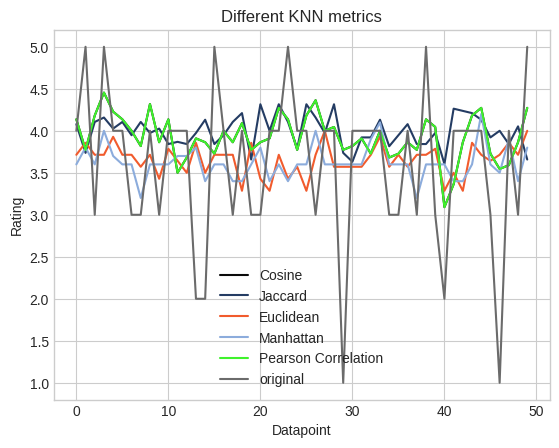

In [30]:
plt.plot(test_cosine, label = "Cosine", color= '#0a0a0a')
plt.plot(test_jaccard, label = "Jaccard", color ='#243c63')
plt.plot(test_euclidean, label = "Euclidean", color ='#f15b2d')
plt.plot(test_manhattan, label = "Manhattan", color ='#8cacdc')
plt.plot(test_pearson, label = "Pearson Correlation", color ='#3ff22c')
plt.plot(original, label = "original", color ='#6b6b6b')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Different KNN metrics')
plt.show()

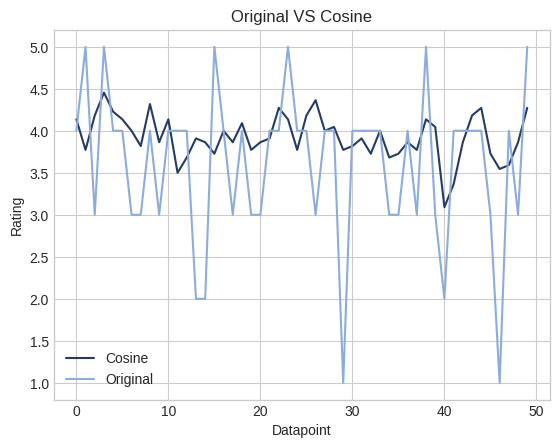

In [ ]:
plt.plot(test_cosine, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

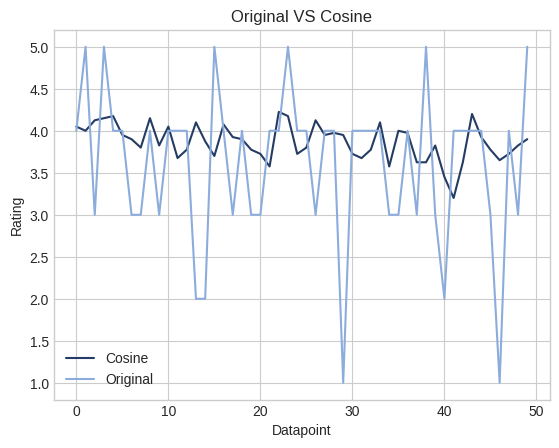

In [ ]:
test_cosine1 = similarity('cosine', l, 20)
plt.plot(test_cosine1, label = "Cosine",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Cosine')
plt.show()

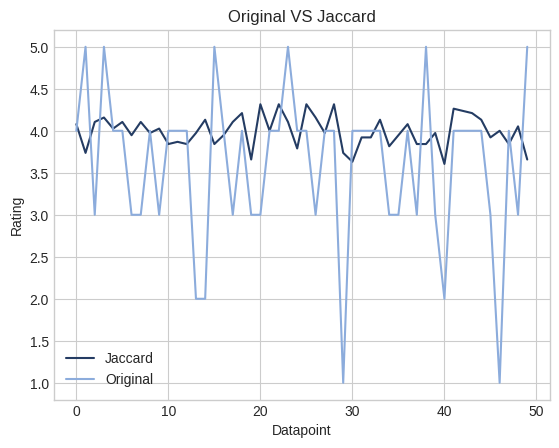

In [ ]:
plt.plot(test_jaccard, label = "Jaccard",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Jaccard')
plt.legend()
plt.show()

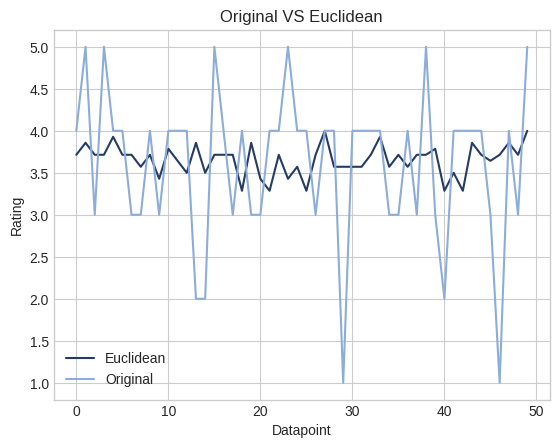

In [ ]:
plt.plot(test_euclidean, label = "Euclidean",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Euclidean')
plt.legend()
plt.show()

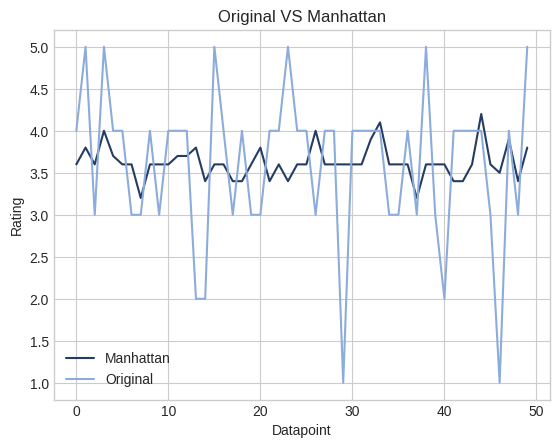

In [ ]:
plt.plot(test_manhattan, label = "Manhattan",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Manhattan')
plt.show()

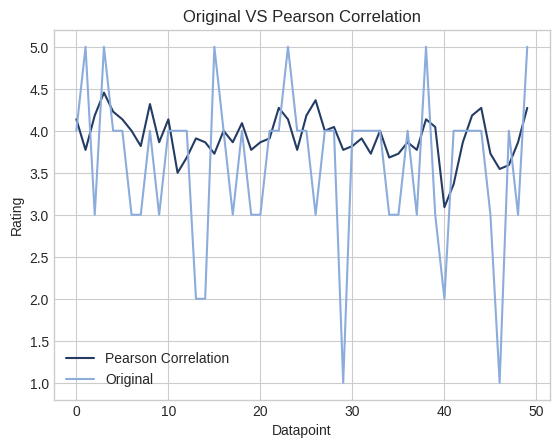

In [31]:
plt.plot(test_pearson, label = "Pearson Correlation",color="#243c63")
plt.plot(original, label = "Original", color ='#8cacdc')
plt.legend()
plt.xlabel("Datapoint")
plt.ylabel("Rating")
plt.title('Original VS Pearson Correlation')
plt.show()

In [32]:
e_cosine =[sklearn.metrics.mean_squared_error(original, test_cosine), mean_absolute_error(original,test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(original, test_jaccard), mean_absolute_error(original,test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(original, test_euclidean), mean_absolute_error(original,test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(original, test_manhattan), mean_absolute_error(original,test_manhattan)]
e_pearson =[sklearn.metrics.mean_squared_error(original, test_pearson), mean_absolute_error(original,test_pearson)]

In [34]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "Pearson correlation similarity": e_pearson},
                index=['RMSE', 'MAE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,Pearson correlation similarity
RMSE,0.824174,1.005042,0.833571,0.8014,0.824174
MAE,0.664545,0.718947,0.715714,0.6980,0.664545


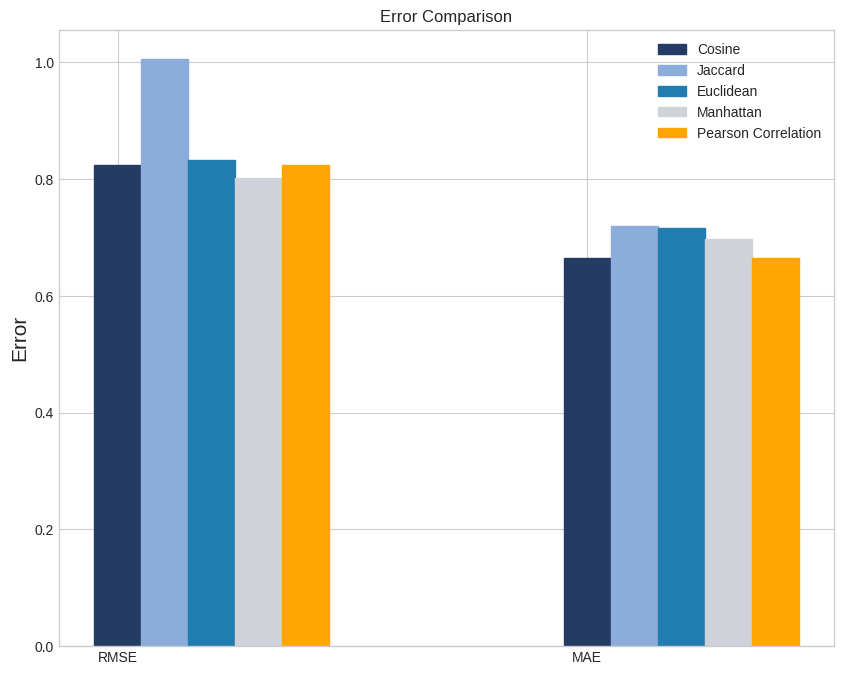

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, e_pearson, color ='orange', width = barWidth,
		edgecolor ='orange', label ='Pearson Correlation')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE' , 'MAE'])

plt.title('Error Comparison')
plt.legend()
plt.show()

In [37]:
test_cosine = similarity('cosine', l, 10)
test_jaccard = similarity('jaccard', l, 10)
test_euclidean = similarity('euclidean', l, 10)
test_manhattan = similarity('manhattan', l, 10)
test_pearson = similarity(correlation, l, 10)

In [38]:
e_cosine =[sklearn.metrics.mean_squared_error(original, test_cosine), mean_absolute_error(original,test_cosine)]
e_jaccard=[sklearn.metrics.mean_squared_error(original, test_jaccard), mean_absolute_error(original,test_jaccard)]
e_euclidean=[sklearn.metrics.mean_squared_error(original, test_euclidean), mean_absolute_error(original,test_euclidean)]
e_manhattan =[sklearn.metrics.mean_squared_error(original, test_manhattan), mean_absolute_error(original,test_manhattan)]
e_pearson =[sklearn.metrics.mean_squared_error(original, test_pearson), mean_absolute_error(original,test_pearson)]

In [39]:
evaluation_df = pd.DataFrame( {
                "Cosine similarity" : e_cosine,
                "Jaccard similarity": e_jaccard,
                "Euclidean similarity": e_euclidean,
                "Manhattan similarity": e_manhattan,
                "Pearson correlation similarity": e_pearson},
                index=['RMSE', 'MAE']
)

evaluation_df

,Cosine similarity,Jaccard similarity,Euclidean similarity,Manhattan similarity,Pearson correlation similarity
RMSE,0.83035,1.13615,0.9029,0.9696,0.83035
MAE,0.66900,0.75300,0.6780,0.6900,0.66900


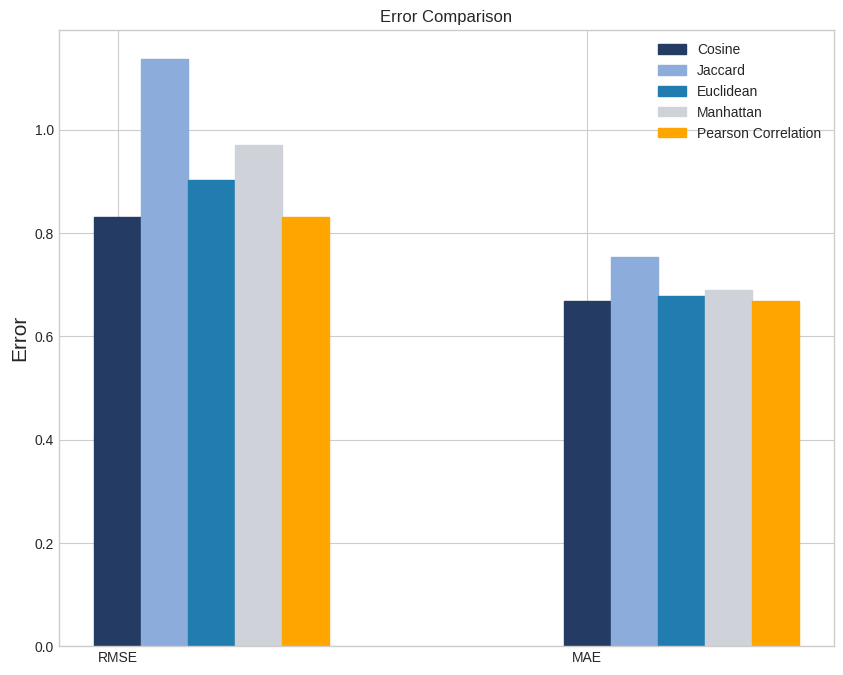

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(10, 8))

# Set position of bar on X axis
br1 = np.arange(len(e_cosine))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br2, e_cosine, color ='#243c63', width = barWidth,
		edgecolor ='#243c63', label ='Cosine')
plt.bar(br3, e_jaccard, color ='#8cacdc', width = barWidth,
		edgecolor ='#8cacdc', label ='Jaccard')
plt.bar(br4, e_euclidean, color ='#217daf', width = barWidth,
		edgecolor ='#217daf', label ='Euclidean')
plt.bar(br5, e_manhattan, color ='#cfd2d8', width = barWidth,
		edgecolor ='#cfd2d8', label ='Manhattan')
plt.bar(br6, e_pearson, color ='orange', width = barWidth,
		edgecolor ='orange', label ='Pearson Correlation')

# Adding Xticks
plt.ylabel('Error', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(e_cosine))],
		['RMSE' , 'MAE'])

plt.title('Error Comparison')
plt.legend()
plt.show()